# Cardiovascular Risk Prediction
# Problem Statement
Predict whether a patient will develop coronary heart disease (CHD) in the next 10 years based on demographic, behavioral, and medical risk factors using machine learning classification models.

# Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import warnings

warnings.filterwarnings('ignore')

# Load Dataset

In [5]:
df = pd.read_csv('data_cardiovascular_risk.csv')
df.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


# Data Cleaning

In [6]:
print(df.isnull().sum())
df['BMI'].fillna(df['BMI'].median(), inplace=True)

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64


In [7]:
print(df.dtypes)
df['sex'] = df['sex'].map({'F': 0, 'M': 1})
df['is_smoking'] = df['is_smoking'].map({'NO': 0, 'YES': 1})
print(df.dtypes)

id                   int64
age                  int64
education          float64
sex                 object
is_smoking          object
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object
id                   int64
age                  int64
education          float64
sex                  int64
is_smoking           int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object


In [8]:
duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')
df.drop_duplicates(inplace=True)
print(df.shape)

Number of duplicate rows: 0
(3390, 17)


# Exploratory Data Analysis (EDA)

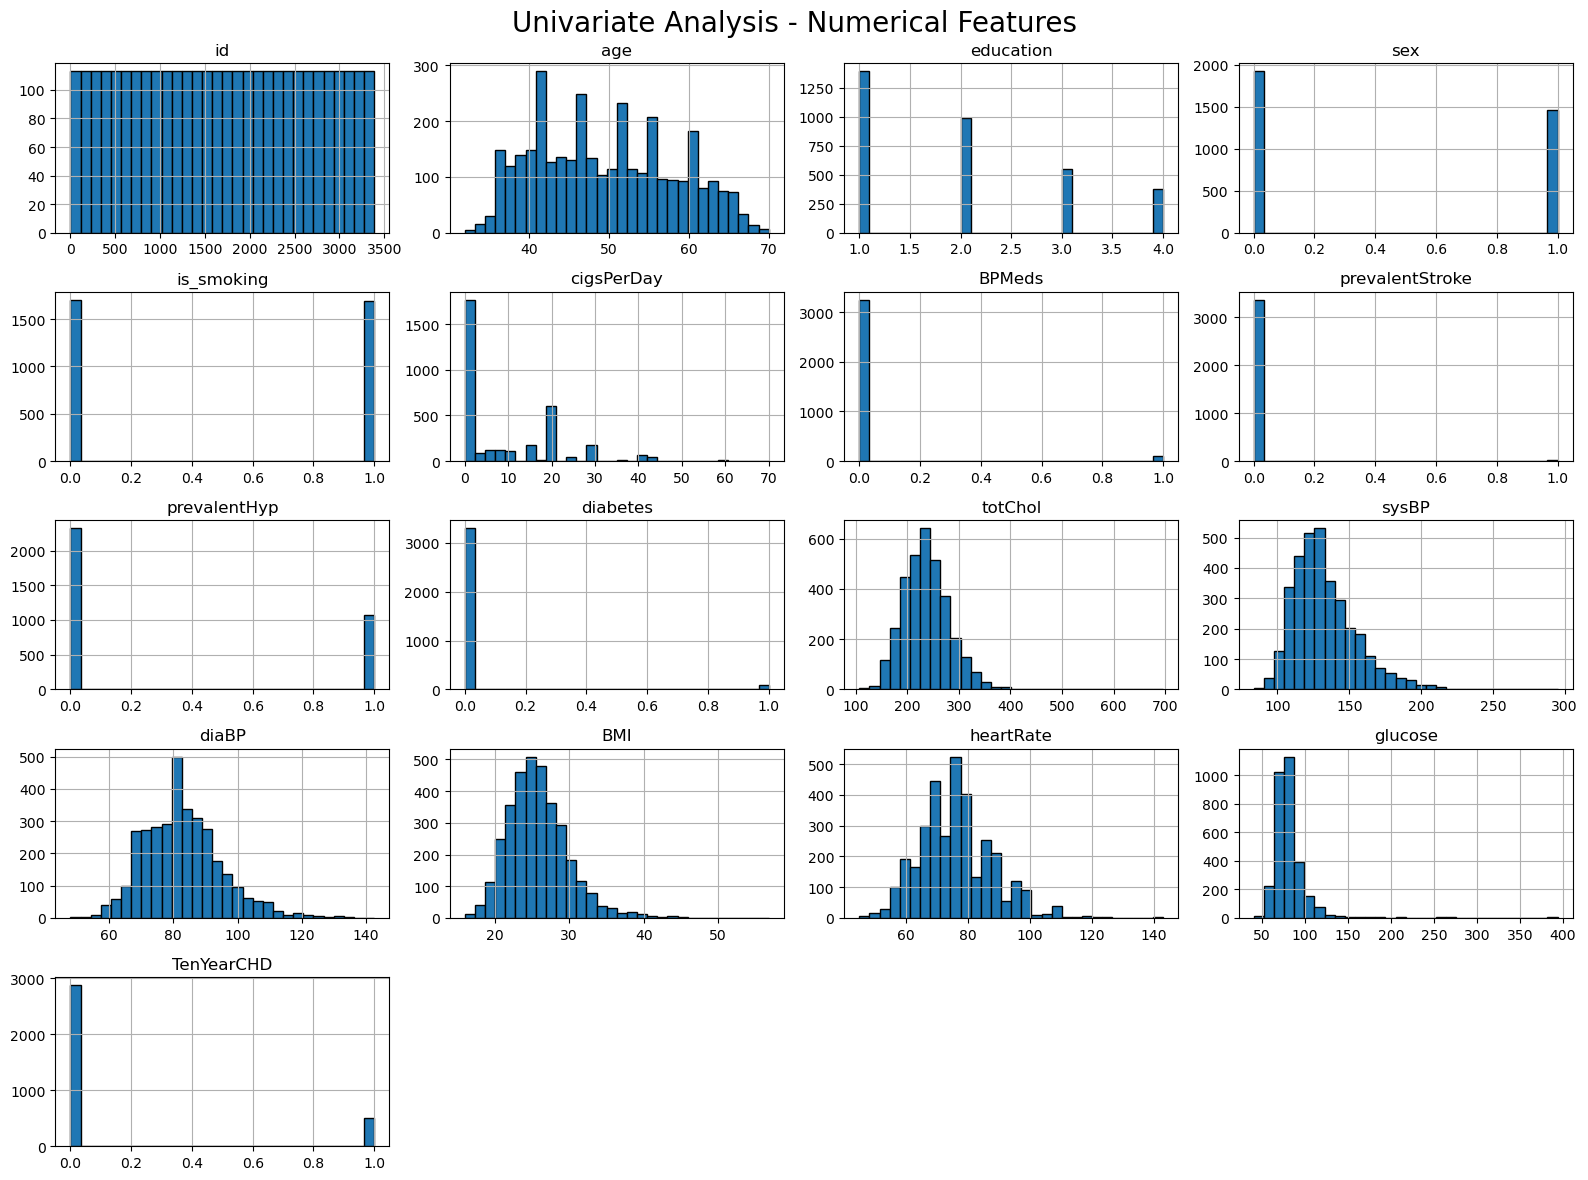

In [9]:
df.hist(figsize=(16,12), bins=30, edgecolor='black')
plt.suptitle('Univariate Analysis - Numerical Features', fontsize=20)
plt.tight_layout()
plt.show()

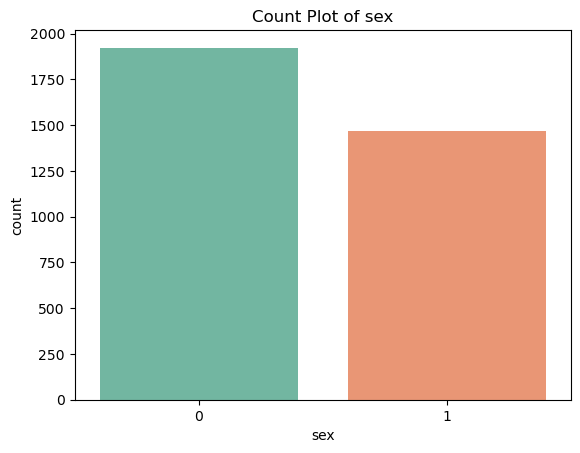

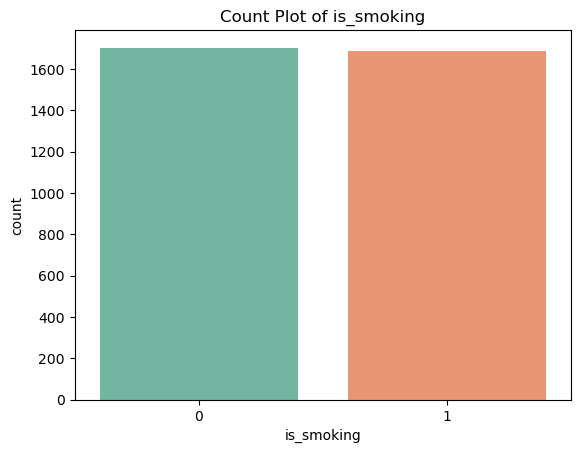

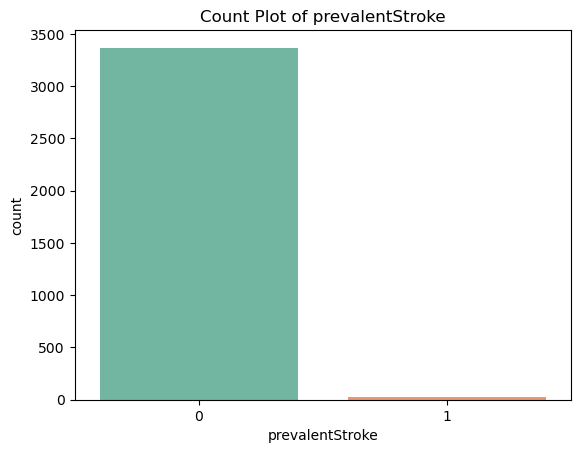

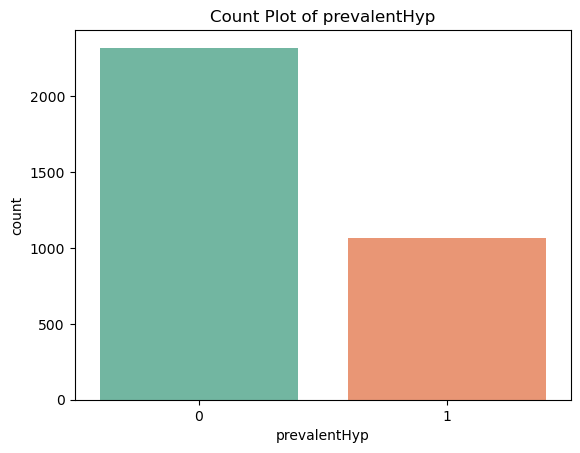

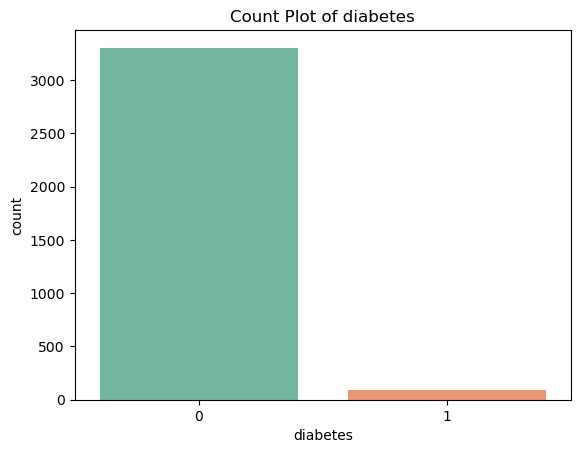

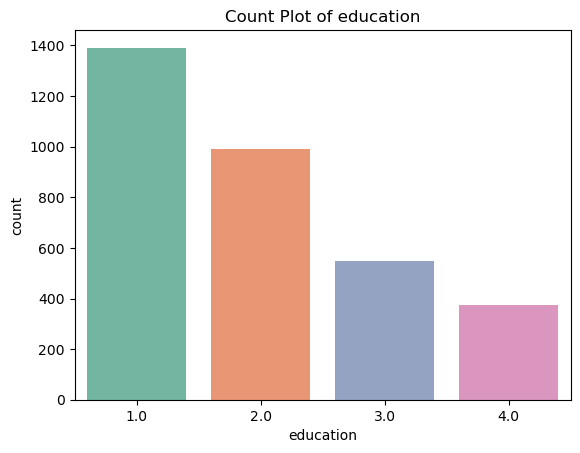

In [10]:
categorical_features = ['sex', 'is_smoking', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'education']
for col in categorical_features:
    sns.countplot(x=col, data=df, palette='Set2')
    plt.title(f'Count Plot of {col}')
    plt.show()

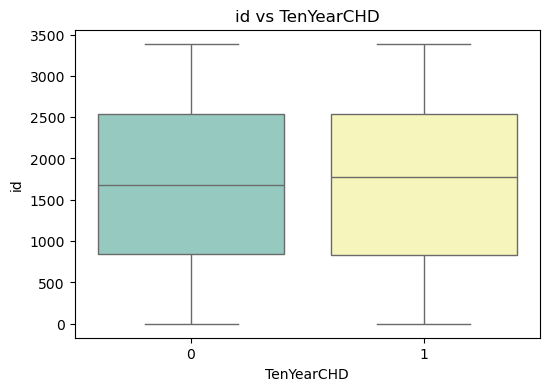

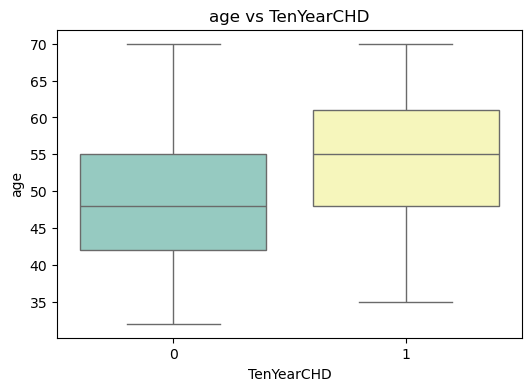

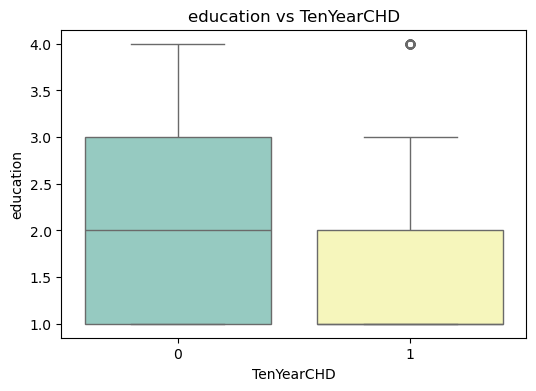

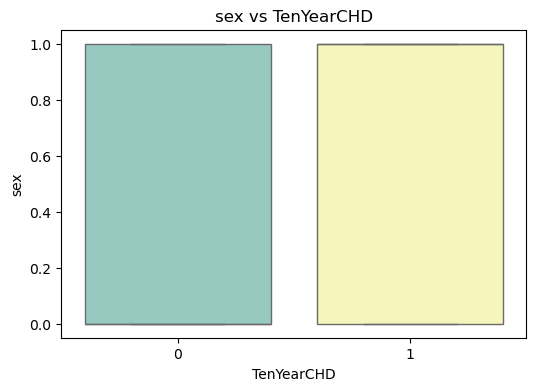

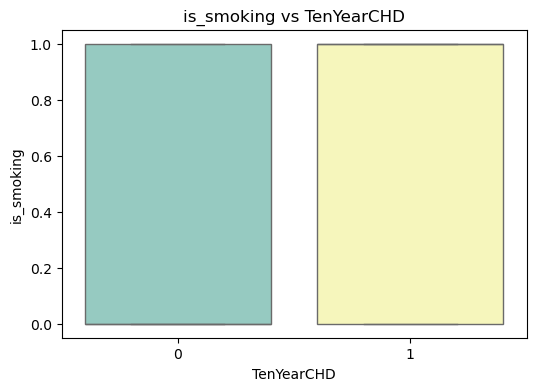

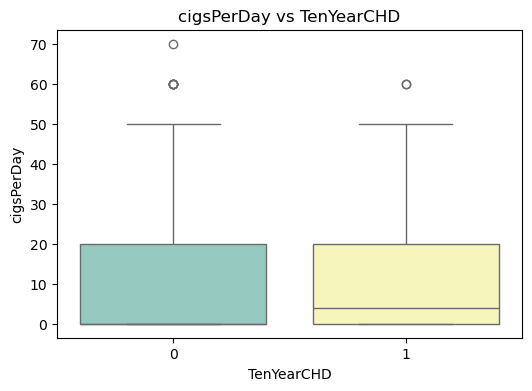

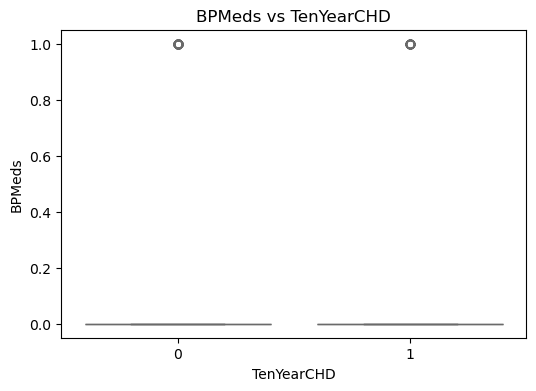

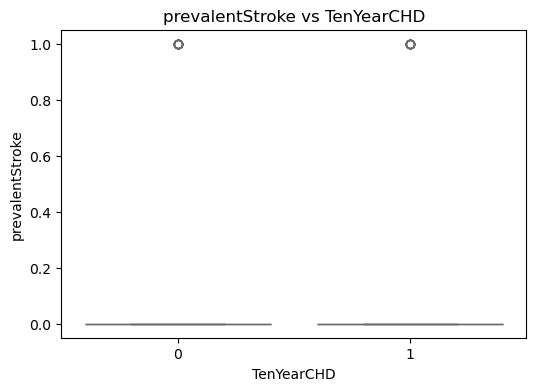

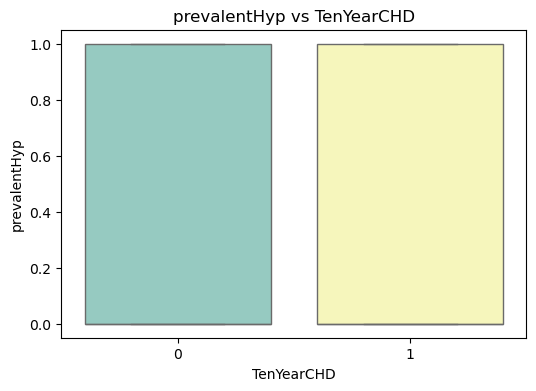

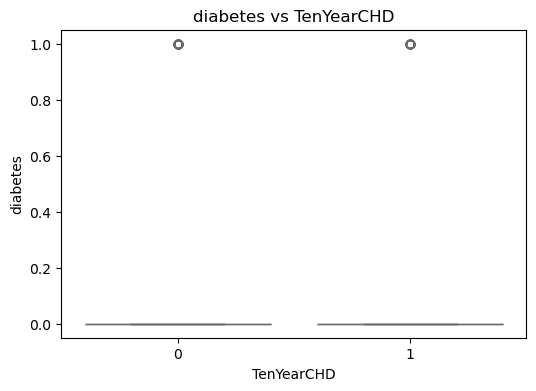

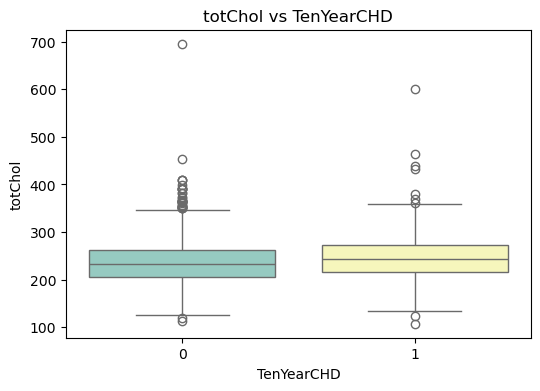

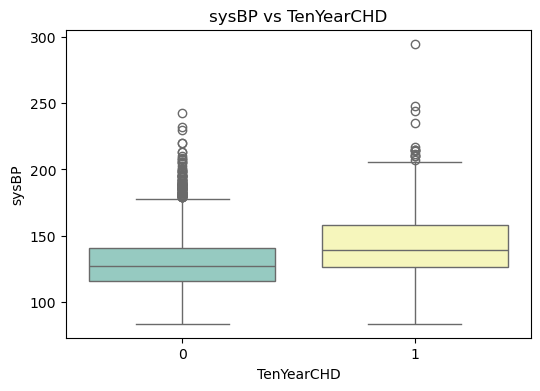

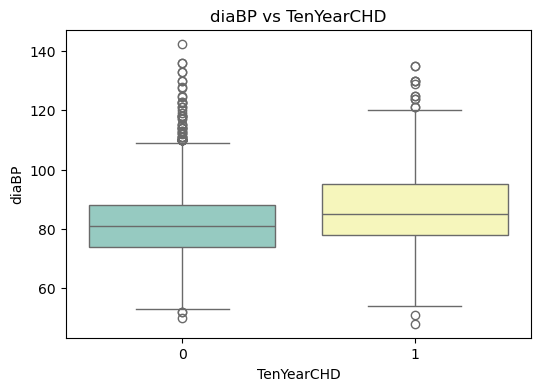

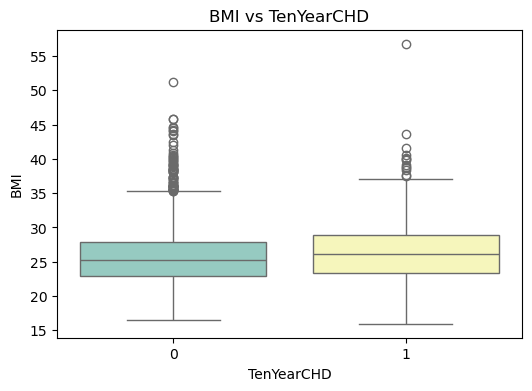

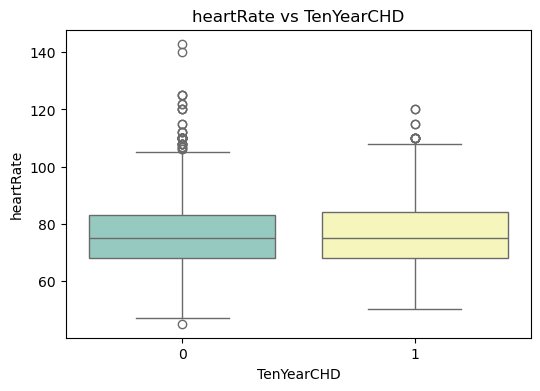

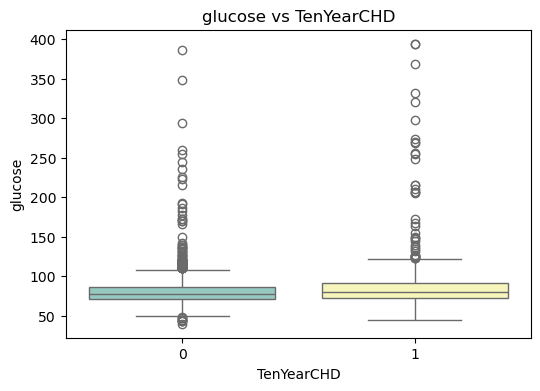

In [11]:
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('TenYearCHD')  
for col in numerical_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='TenYearCHD', y=col, data=df, palette='Set3')
    plt.title(f'{col} vs TenYearCHD')
    plt.show()

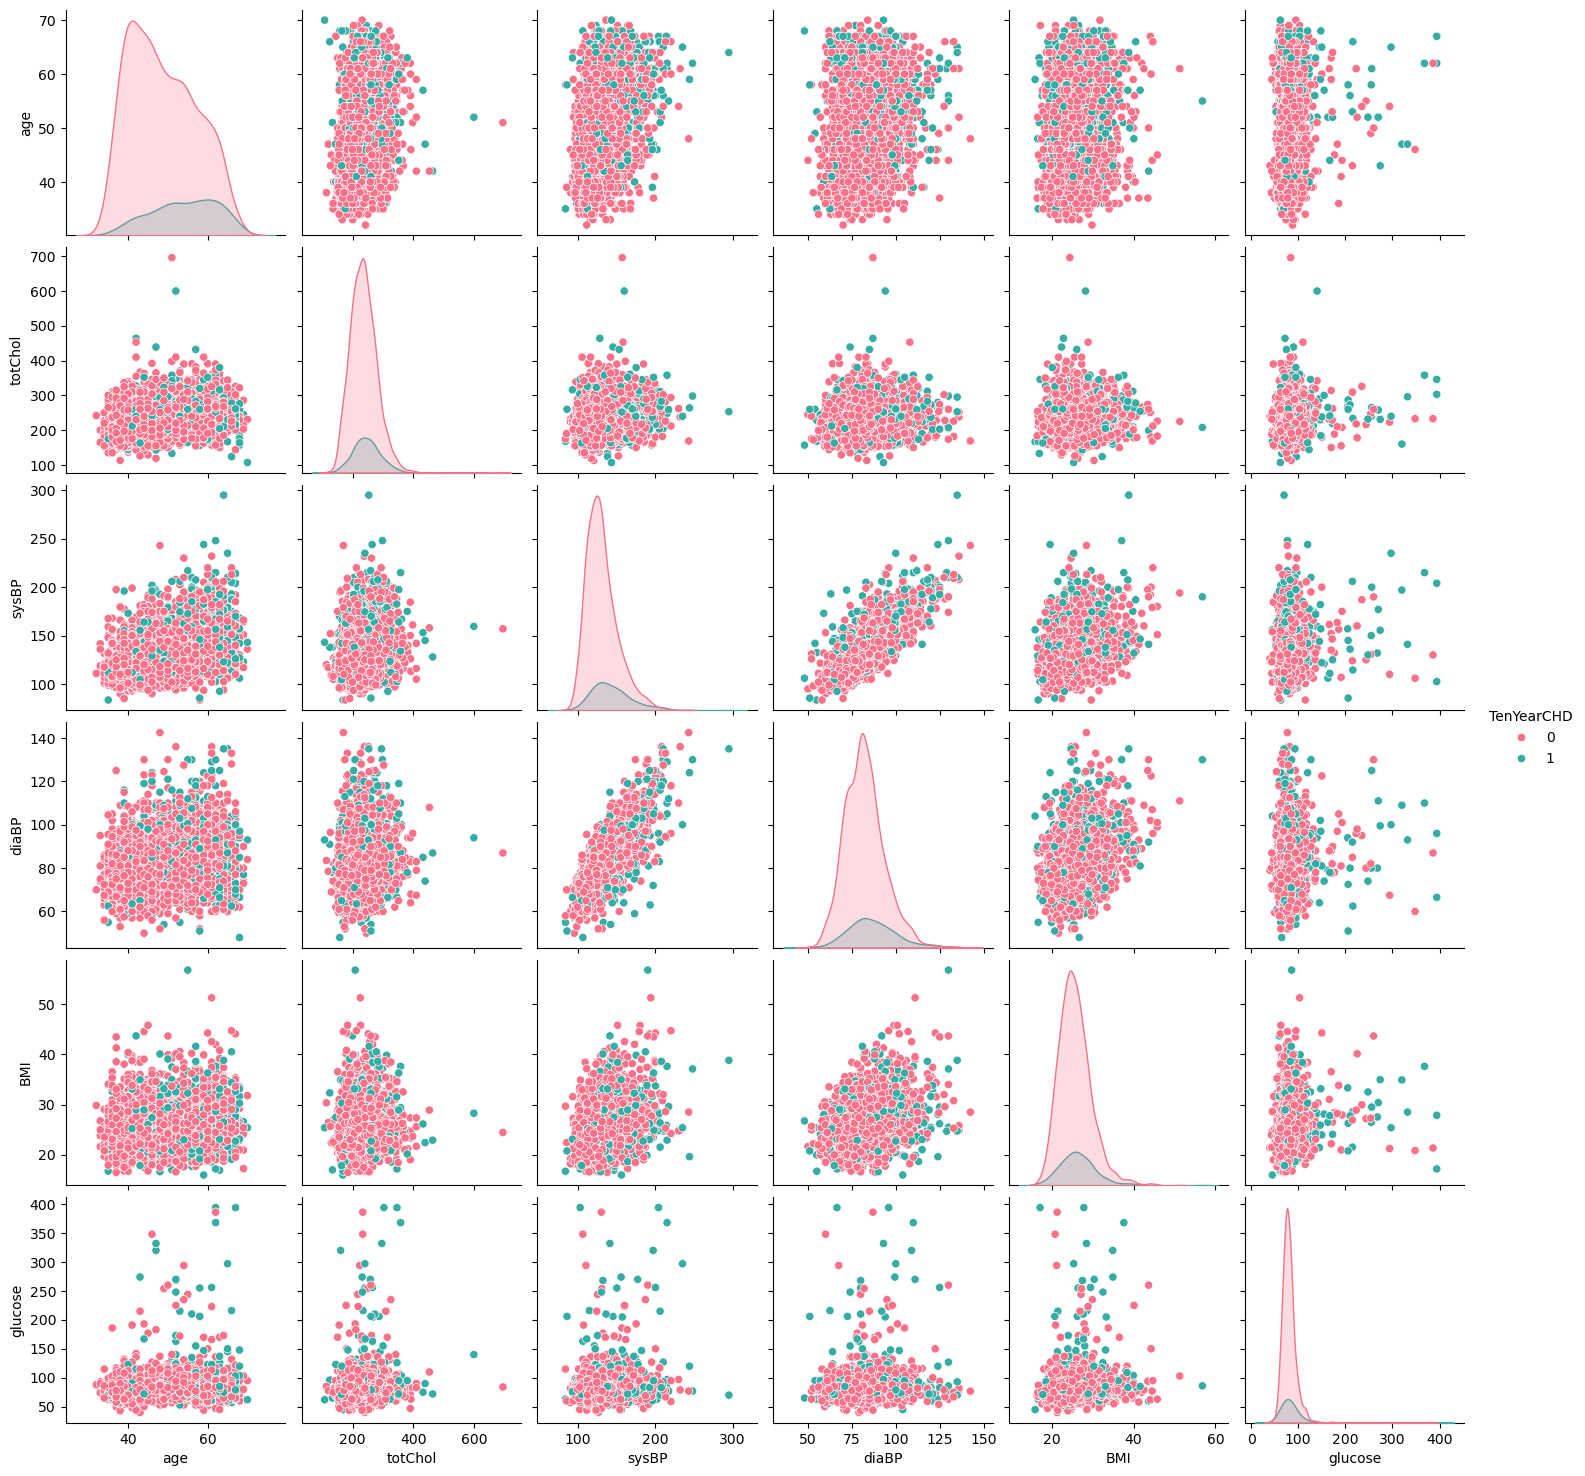

In [12]:
important_cols = ['age', 'totChol', 'sysBP', 'diaBP', 'BMI', 'glucose', 'TenYearCHD']
sns.pairplot(df[important_cols], hue='TenYearCHD', palette='husl')
plt.show()

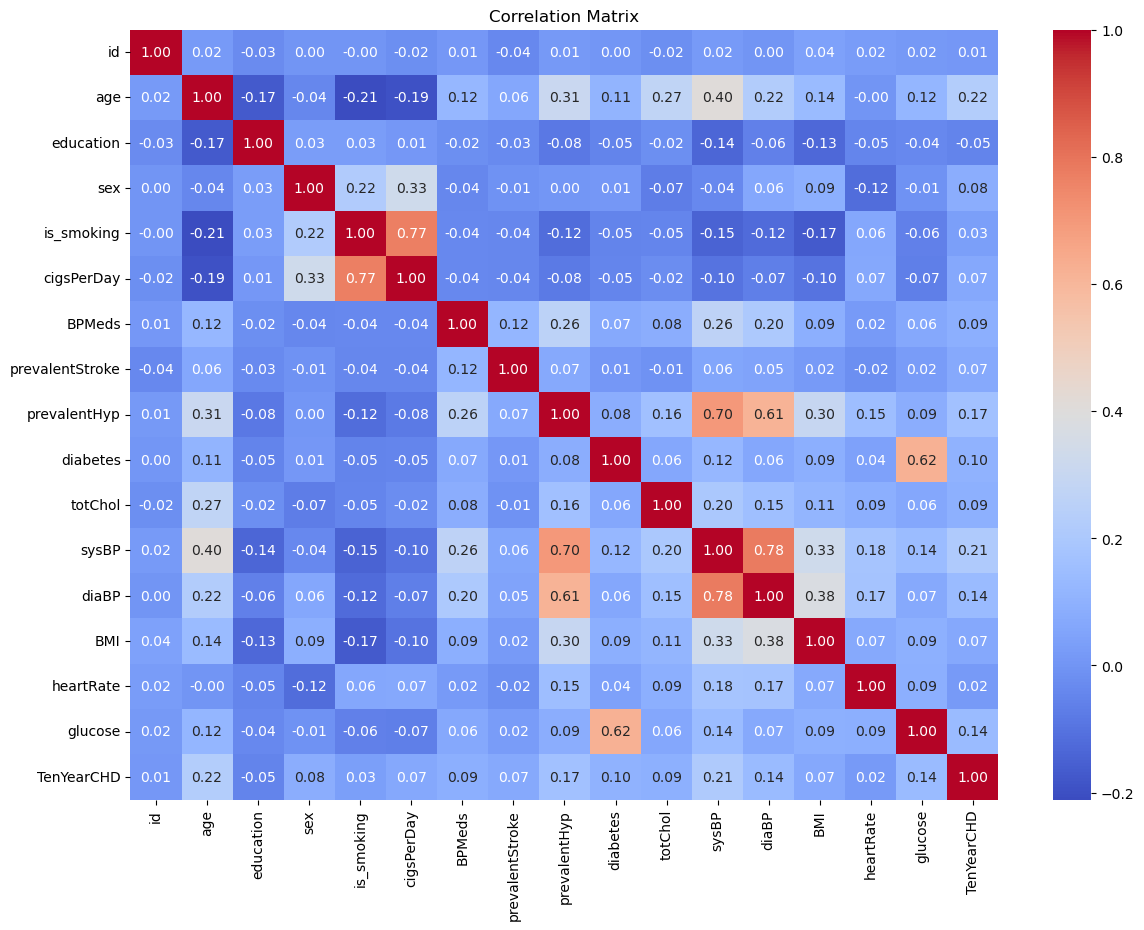

In [13]:
plt.figure(figsize=(14,10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

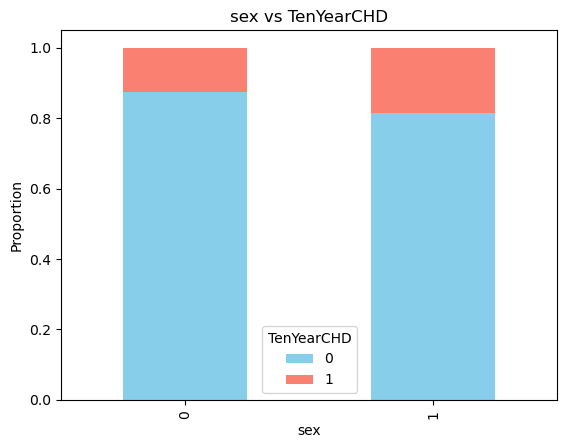

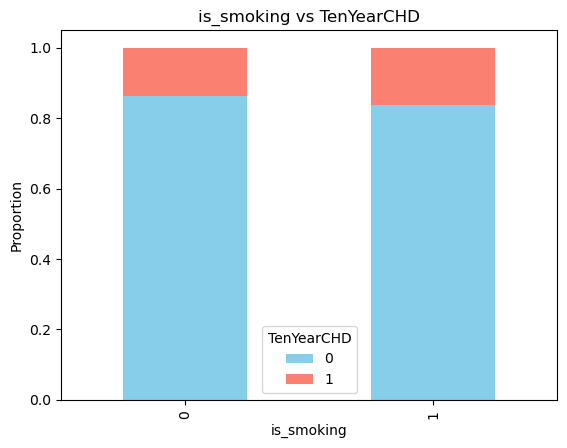

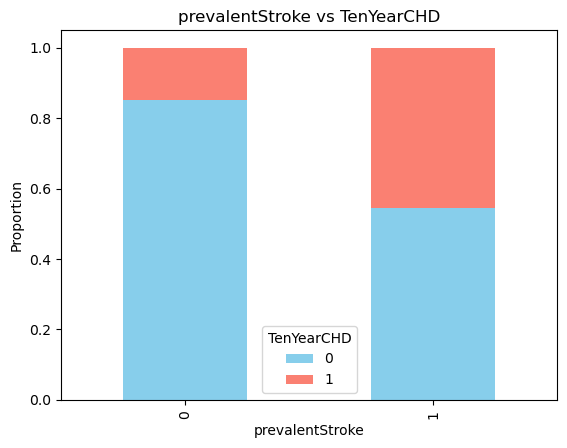

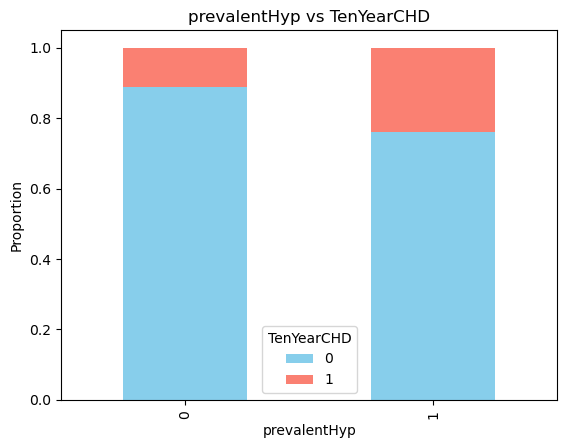

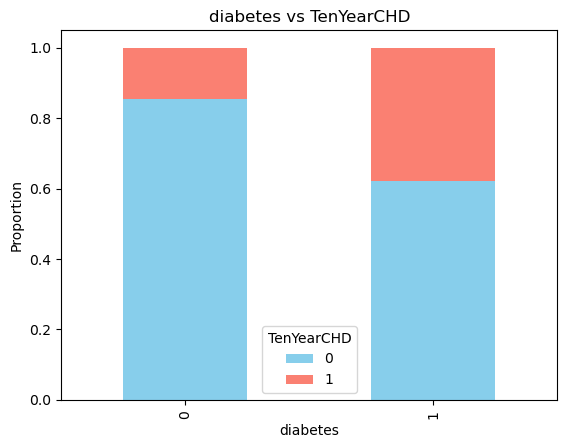

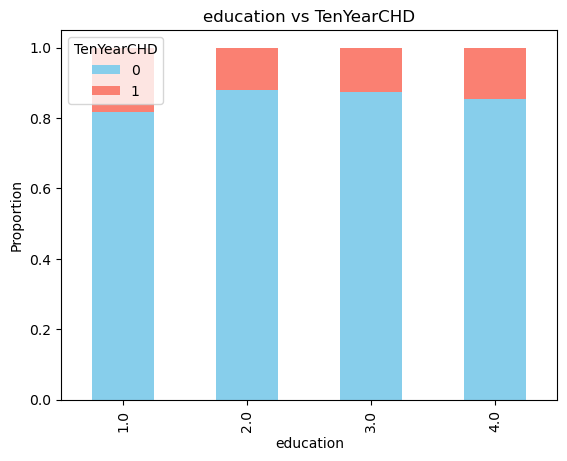

In [14]:
for col in categorical_features:
    cross_tab = pd.crosstab(df[col], df['TenYearCHD'], normalize='index')
    cross_tab.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
    plt.title(f'{col} vs TenYearCHD')
    plt.ylabel('Proportion')
    plt.show()

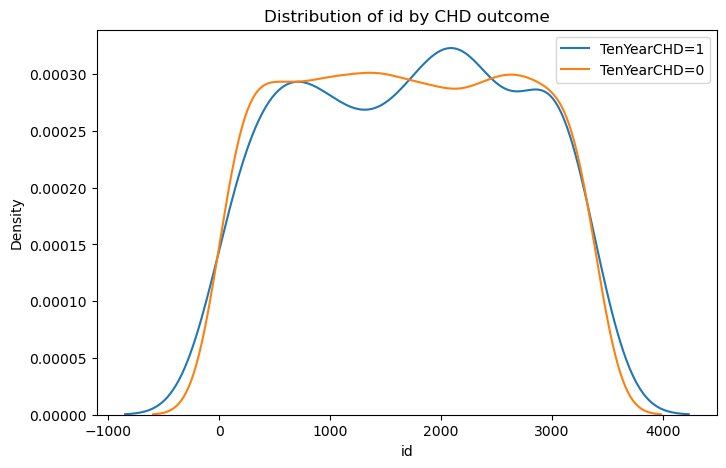

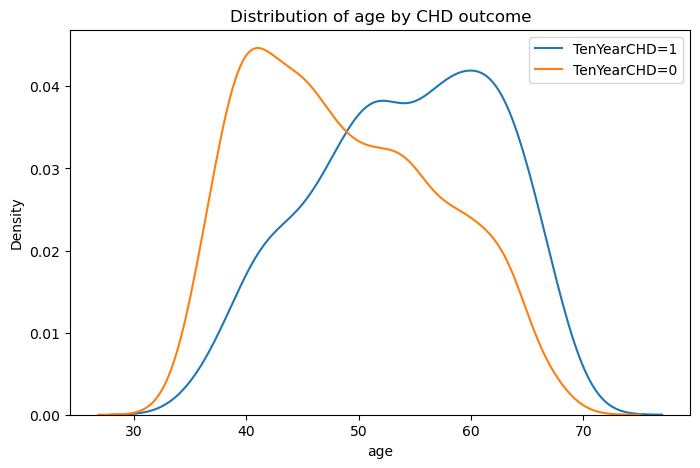

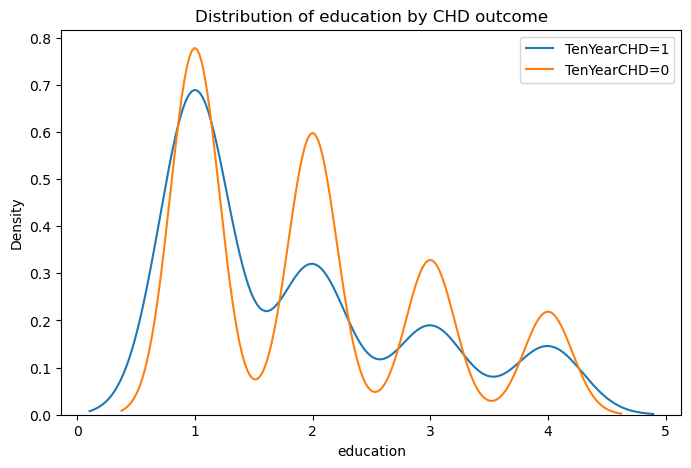

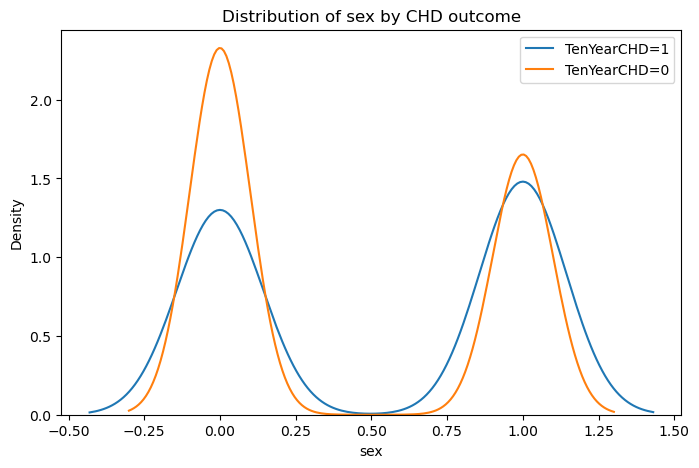

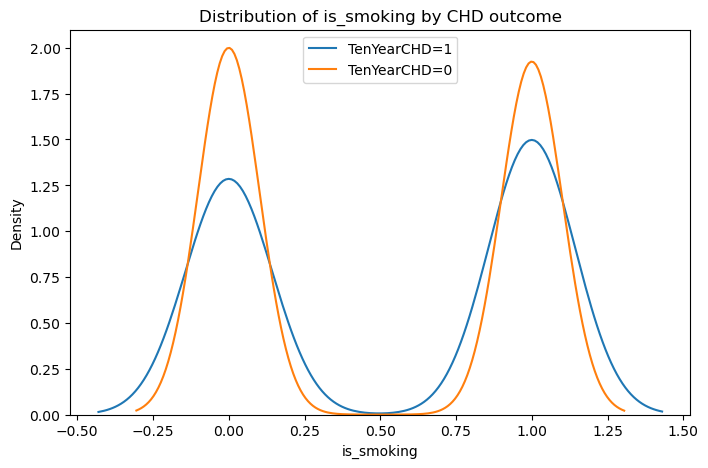

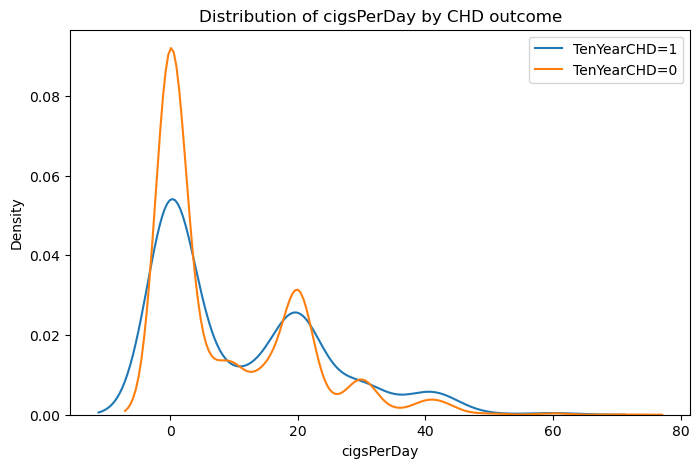

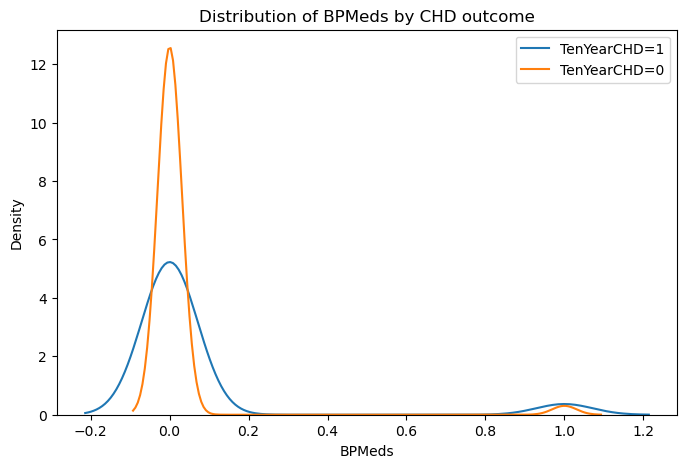

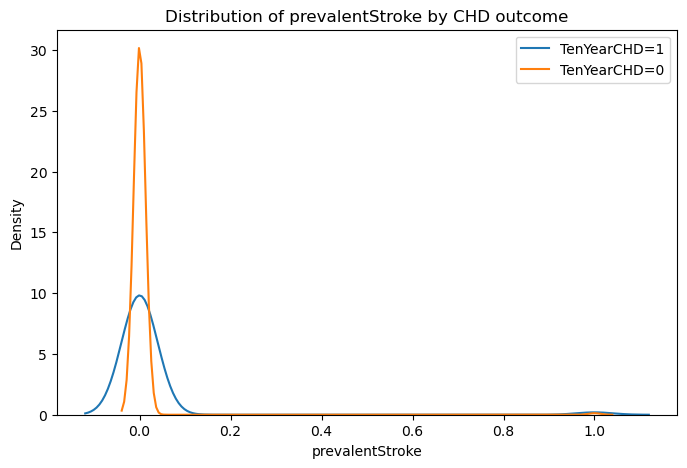

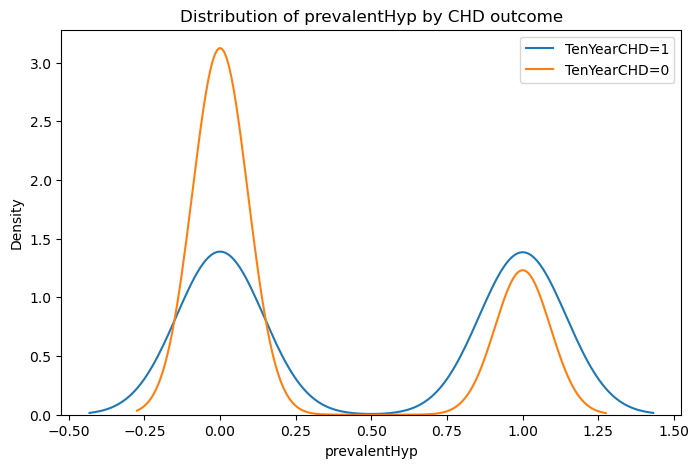

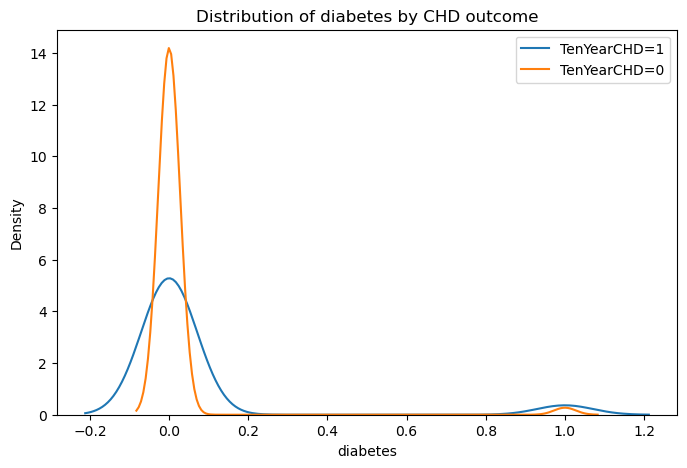

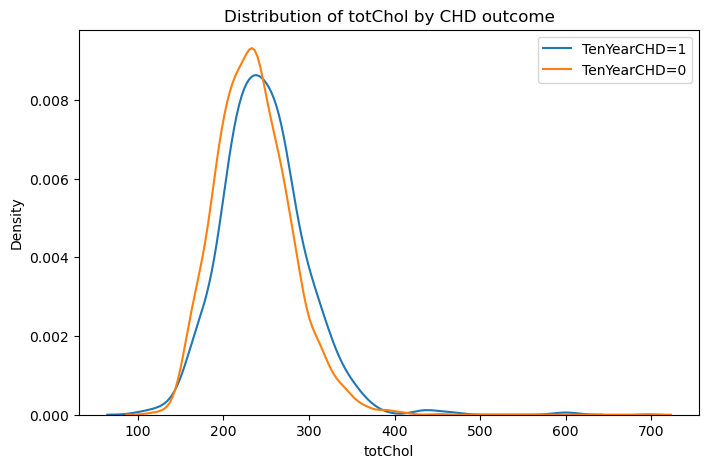

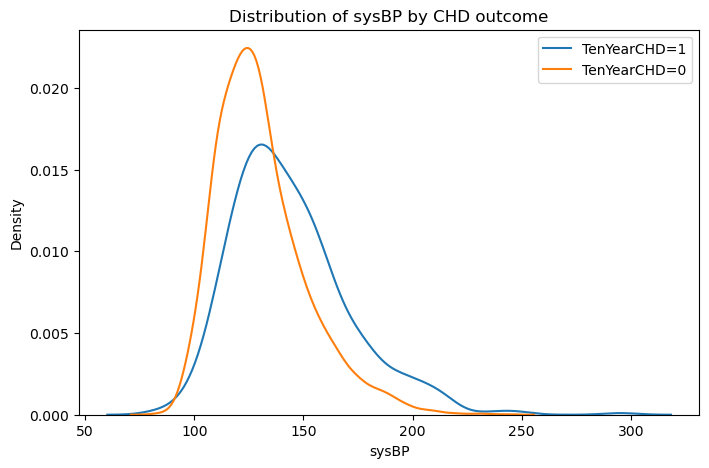

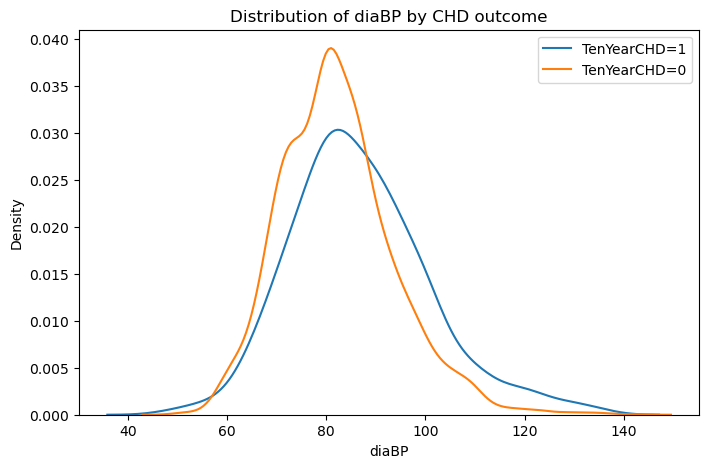

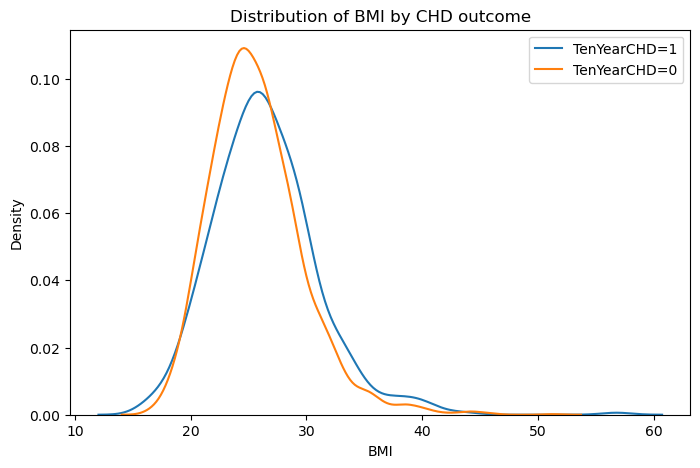

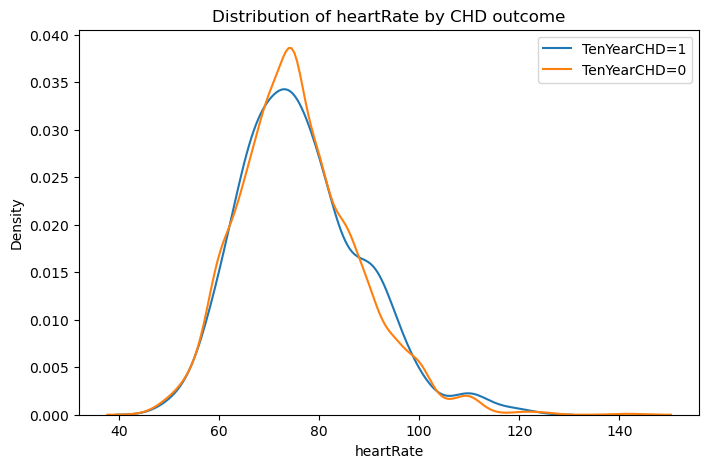

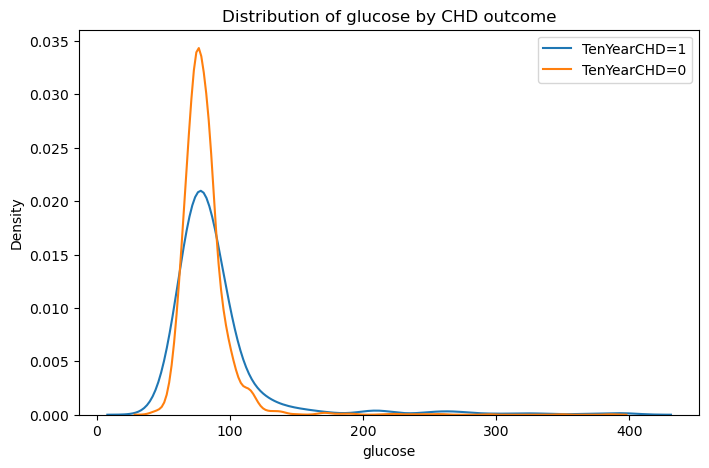

In [15]:
for col in numerical_features:
    plt.figure(figsize=(8,5))
    for target in df['TenYearCHD'].unique():
        sns.kdeplot(df[df['TenYearCHD'] == target][col], label=f'TenYearCHD={target}')
    plt.title(f'Distribution of {col} by CHD outcome')
    plt.legend()
    plt.show()

# Outlier treatment

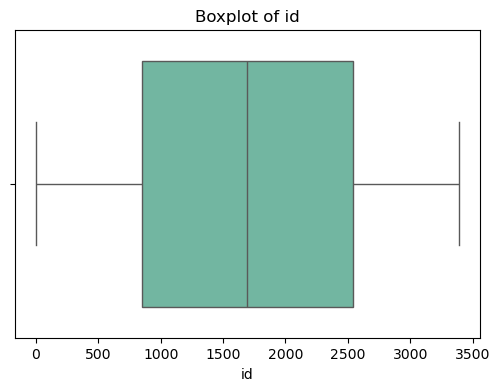

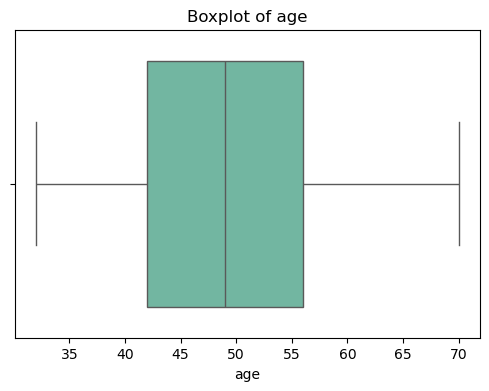

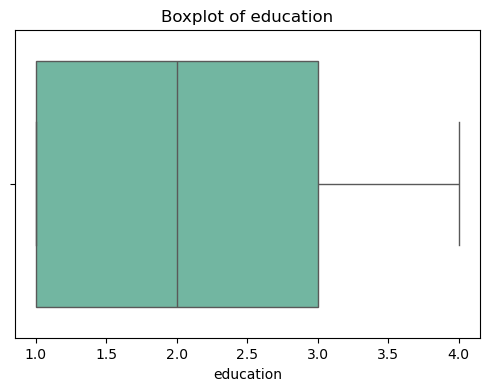

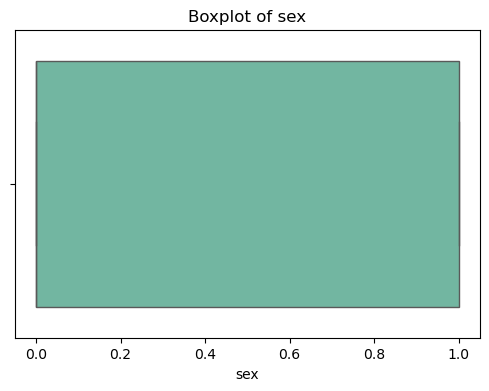

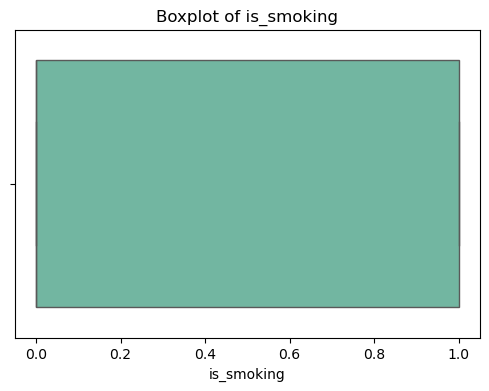

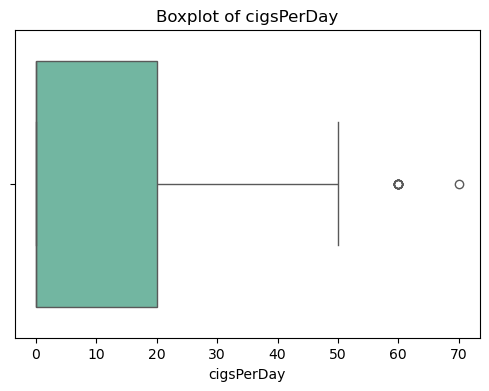

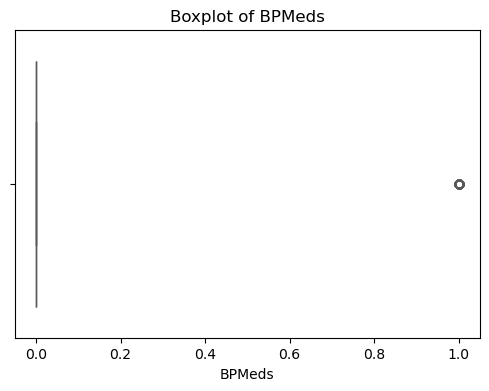

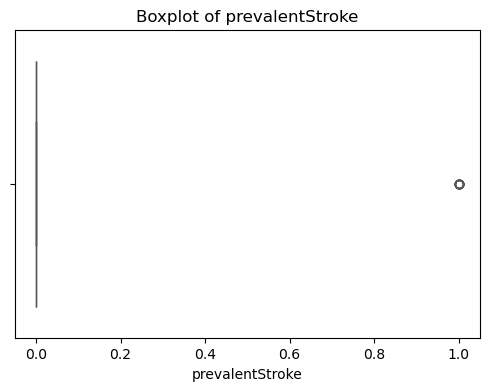

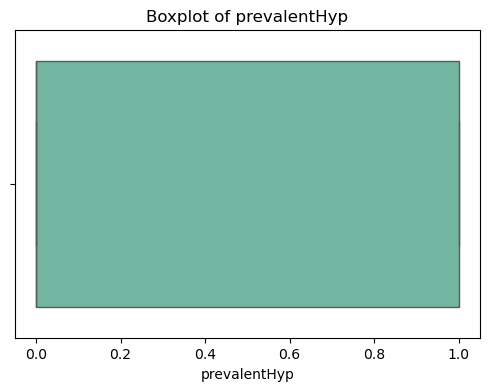

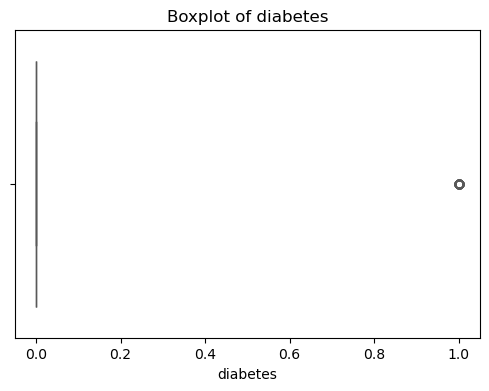

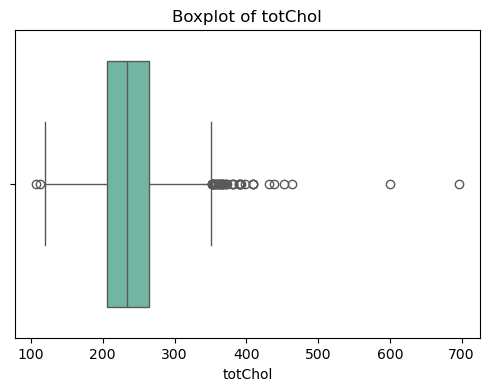

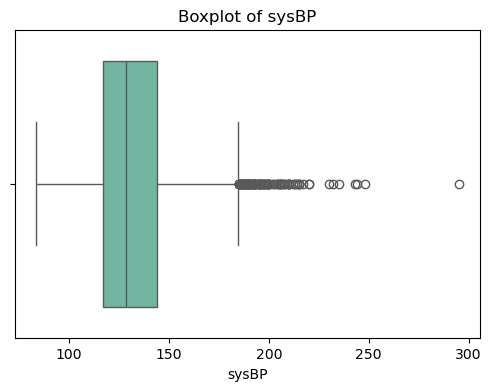

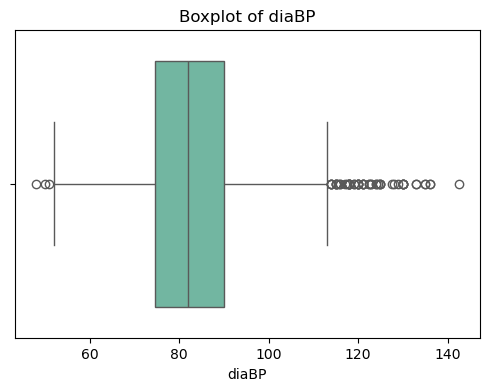

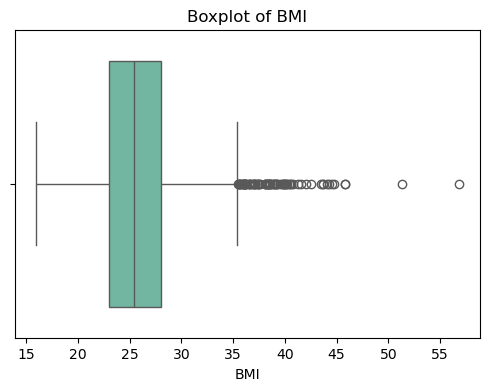

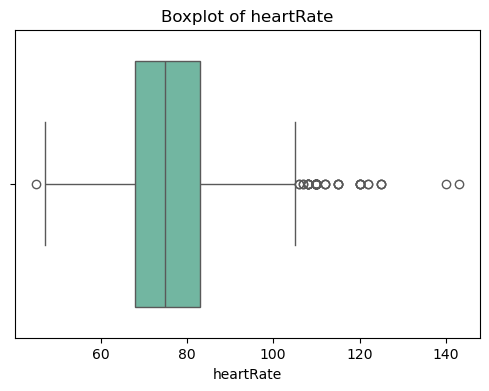

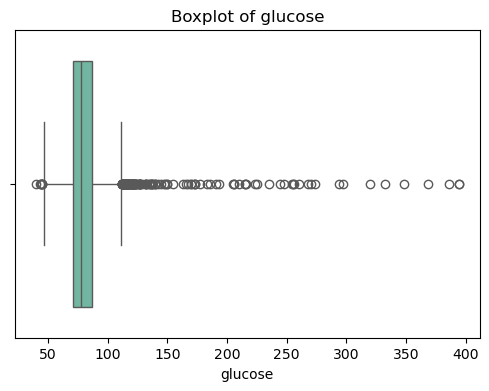

In [16]:
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('TenYearCHD')
for col in numerical_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], palette='Set2')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

In [17]:
def cap_outliers(series):
    lower_limit = series.quantile(0.01)
    upper_limit = series.quantile(0.99)
    return np.clip(series, lower_limit, upper_limit)
for col in numerical_features:
    df[col] = cap_outliers(df[col])

In [18]:
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

outliers_in_sysBP = detect_outliers(df['sysBP'])
print(f'Number of outliers in sysBP: {len(outliers_in_sysBP)}')

Number of outliers in sysBP: 105


# Check Distributions & Apply Transformations

In [19]:
from scipy.stats import skew, kurtosis
for col in numerical_features:
    print(f"{col}: Skewness = {skew(df[col]):.2f}, Kurtosis = {kurtosis(df[col]):.2f}")

id: Skewness = 0.00, Kurtosis = -1.20
age: Skewness = 0.22, Kurtosis = -1.04
education: Skewness = nan, Kurtosis = nan
sex: Skewness = 0.27, Kurtosis = -1.93
is_smoking: Skewness = 0.01, Kurtosis = -2.00
cigsPerDay: Skewness = nan, Kurtosis = nan
BPMeds: Skewness = nan, Kurtosis = nan
prevalentStroke: Skewness = nan, Kurtosis = nan
prevalentHyp: Skewness = 0.79, Kurtosis = -1.37
diabetes: Skewness = 6.00, Kurtosis = 33.99
totChol: Skewness = nan, Kurtosis = nan
sysBP: Skewness = 0.95, Kurtosis = 0.79
diaBP: Skewness = 0.58, Kurtosis = 0.39
BMI: Skewness = 0.72, Kurtosis = 0.78
heartRate: Skewness = nan, Kurtosis = nan
glucose: Skewness = nan, Kurtosis = nan


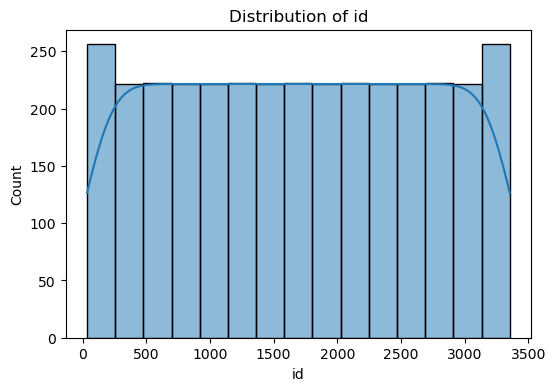

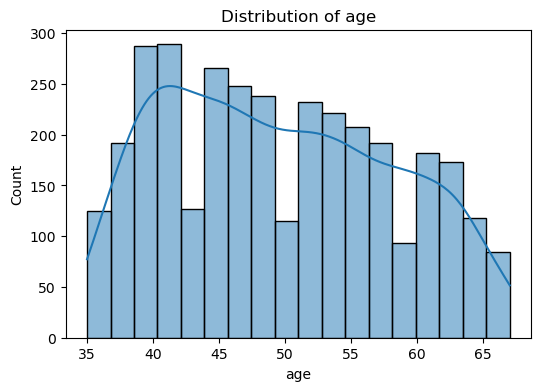

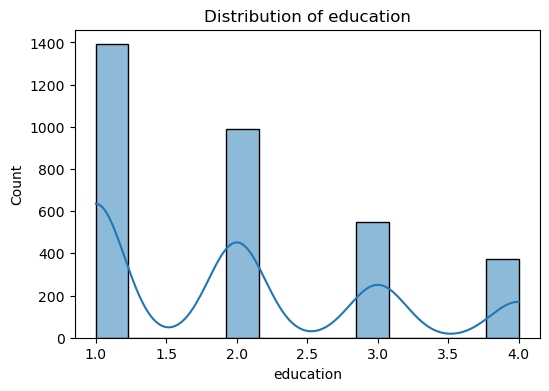

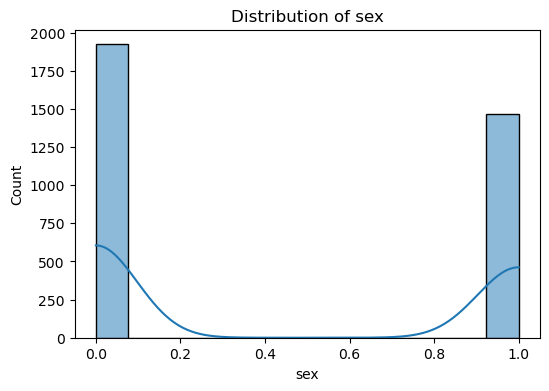

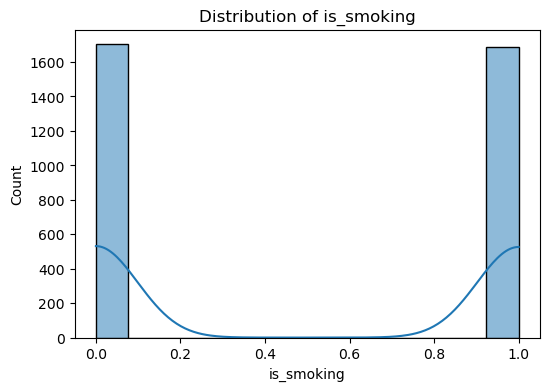

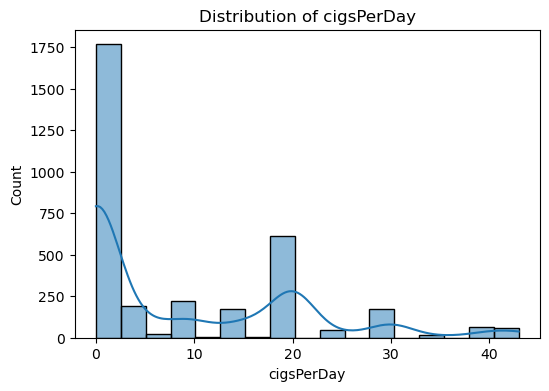

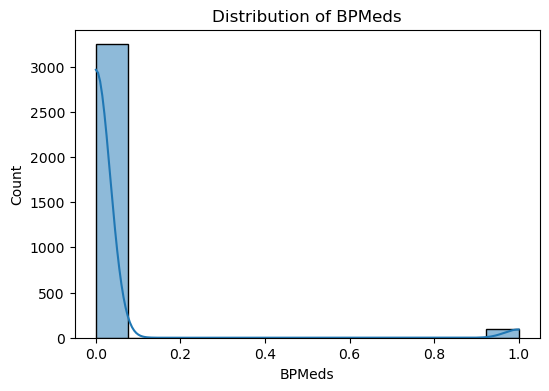

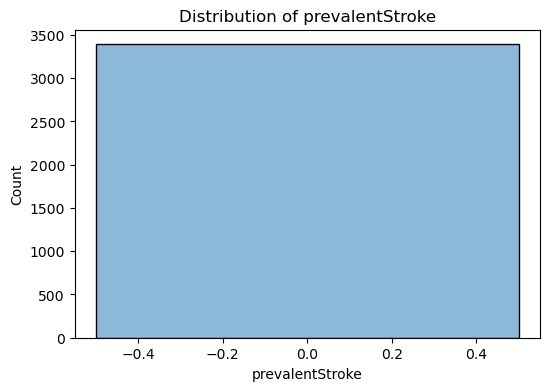

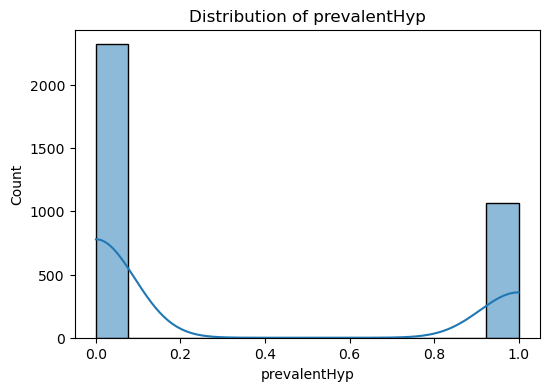

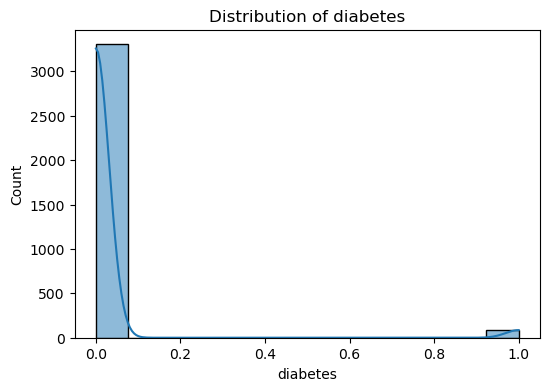

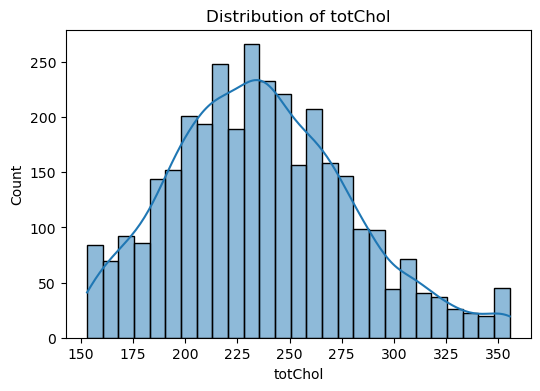

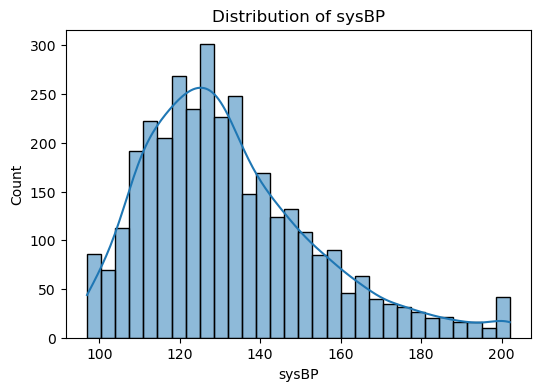

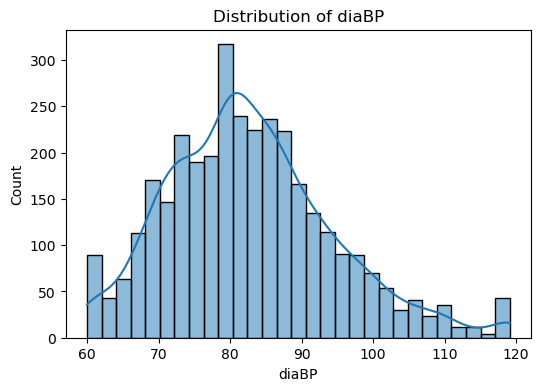

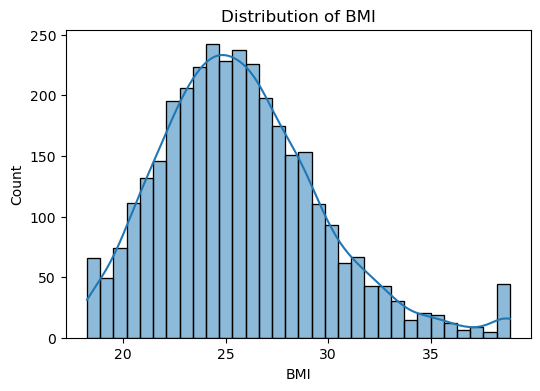

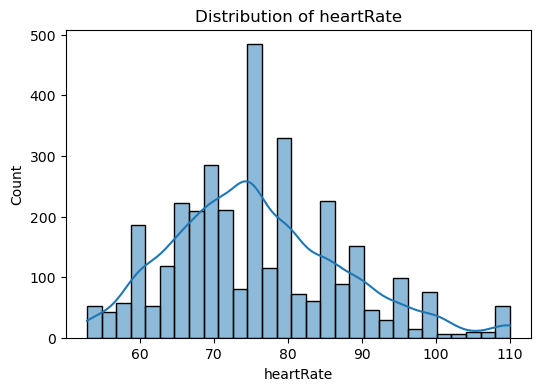

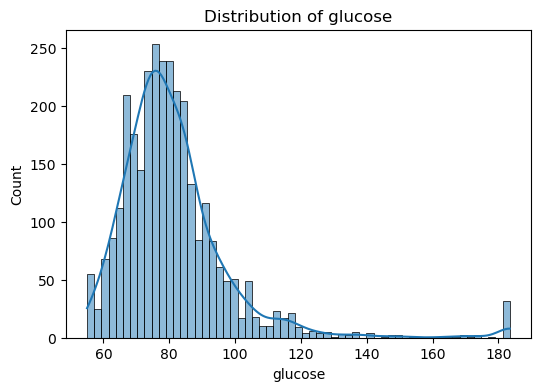

In [20]:
for col in numerical_features:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

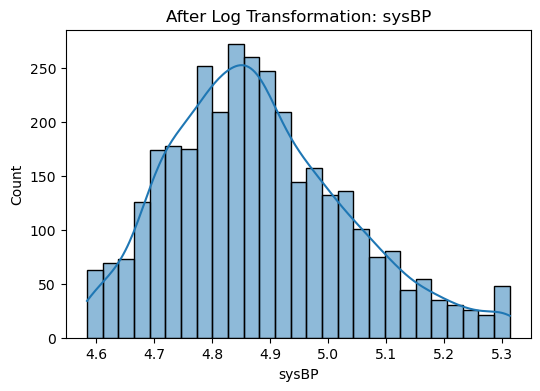

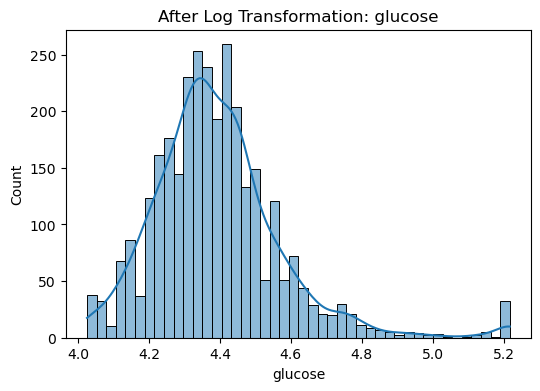

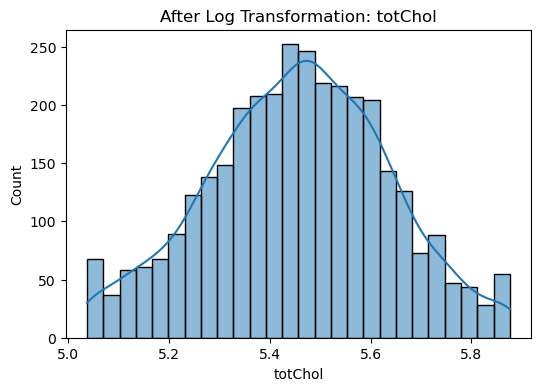

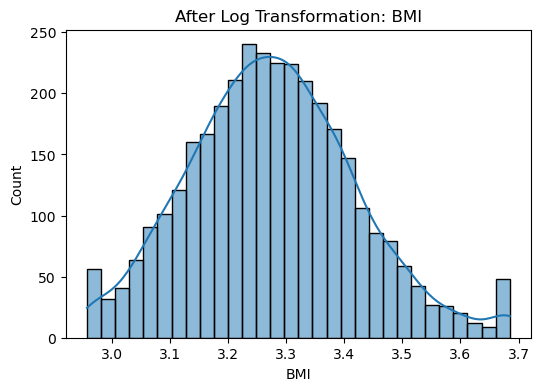

In [21]:
skewed_cols = ['sysBP', 'glucose', 'totChol', 'BMI']
for col in skewed_cols:
    df[col] = np.log1p(df[col])
for col in skewed_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'After Log Transformation: {col}')
    plt.show()

# Feature Engineering

In [22]:
df['pulse_pressure'] = df['sysBP'] - df['diaBP']

In [24]:
df['age_group'] = pd.cut(df['age'], 
                         bins=[0, 39, 59, 100], 
                         labels=['Young', 'Middle-aged', 'Old'])

In [25]:
df['BMI_category'] = pd.cut(df['BMI'],
                            bins=[0, 18.5, 24.9, 29.9, 100],
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

In [26]:
df = pd.get_dummies(df, columns=['education', 'age_group', 'BMI_category'], drop_first=True)

# Split Data into Train/Test Sets

In [27]:
X = df.drop('TenYearCHD', axis=1)
y = df['TenYearCHD']

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

# Train Logistic Regression Model

In [29]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000, random_state=42)

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [34]:
logreg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [35]:
y_pred_logreg = logreg.predict(X_test_scaled)

# Feature Scaling

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Prediction using the Logistic Regression Algorithm

In [41]:
y_pred_logreg = logreg.predict(X_test_scaled)
y_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

# Evaluate Model Performance Using Confusion Matrix and Metrics

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[574   2]
 [ 99   3]]


In [43]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Accuracy:", accuracy)

Accuracy: 0.8510324483775811


In [44]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred_logreg)
print("Precision:", precision)

Precision: 0.6


In [45]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred_logreg)
print("Recall:", recall)

Recall: 0.029411764705882353


In [46]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_logreg)
print("F1 Score:", f1)

F1 Score: 0.056074766355140186


# Perform the same steps for
○ Decision tree Classifier
○ Random Forest Classifier
○ Support Vector Machine Classifier
○ K Nearest Neighbor Classifier

In [47]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_scaled, y_train)
y_pred_dt = dt_classifier.predict(X_test_scaled)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
print("Decision Tree Classifier Results:")
print(f"Accuracy: {dt_accuracy}")
print(f"Precision: {dt_precision}")
print(f"Recall: {dt_recall}")
print(f"F1 Score: {dt_f1}")

Decision Tree Classifier Results:
Accuracy: 0.7713864306784661
Precision: 0.25688073394495414
Recall: 0.27450980392156865
F1 Score: 0.26540284360189575


In [48]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_scaled, y_train)
y_pred_rf = rf_classifier.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
print("Random Forest Classifier Results:")
print(f"Accuracy: {rf_accuracy}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1 Score: {rf_f1}")

Random Forest Classifier Results:
Accuracy: 0.8480825958702065
Precision: 0.4444444444444444
Recall: 0.0392156862745098
F1 Score: 0.07207207207207207


In [49]:
from sklearn.svm import SVC
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train_scaled, y_train)
y_pred_svm = svm_classifier.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)
print("Support Vector Machine Classifier Results:")
print(f"Accuracy: {svm_accuracy}")
print(f"Precision: {svm_precision}")
print(f"Recall: {svm_recall}")
print(f"F1 Score: {svm_f1}")

Support Vector Machine Classifier Results:
Accuracy: 0.8480825958702065
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


In [51]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_scaled, y_train)
y_pred_knn = knn_classifier.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn)
knn_recall = recall_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)
print("K Nearest Neighbor Classifier Results:")
print(f"Accuracy: {knn_accuracy}")
print(f"Precision: {knn_precision}")
print(f"Recall: {knn_recall}")
print(f"F1 Score: {knn_f1}")

K Nearest Neighbor Classifier Results:
Accuracy: 0.8333333333333334
Precision: 0.17647058823529413
Recall: 0.029411764705882353
F1 Score: 0.05042016806722689


# Perform the Cross Validation using Cross_val_score for all the algorithms

In [67]:
from sklearn.preprocessing import StandardScaler
X_clean = X.dropna() 
y_clean = y[X_clean.index] 

scaler = StandardScaler()
X_scaled_clean = scaler.fit_transform(X_clean)

logreg = LogisticRegression(random_state=42)
logreg_cv = cross_val_score(logreg, X_scaled_clean, y_clean, cv=5, scoring='accuracy')
print("Logistic Regression - Cross Validation Accuracy:")
print(f"Mean Accuracy: {logreg_cv.mean()} (+/- {logreg_cv.std() * 2})\n")

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_cv = cross_val_score(dt_classifier, X_scaled_clean, y_clean, cv=5, scoring='accuracy')
print("Decision Tree Classifier - Cross Validation Accuracy:")
print(f"Mean Accuracy: {dt_cv.mean()} (+/- {dt_cv.std() * 2})\n")

rf_classifier = RandomForestClassifier(random_state=42)
rf_cv = cross_val_score(rf_classifier, X_scaled_clean, y_clean, cv=5, scoring='accuracy')
print("Random Forest Classifier - Cross Validation Accuracy:")
print(f"Mean Accuracy: {rf_cv.mean()} (+/- {rf_cv.std() * 2})\n")

svm_classifier = SVC(random_state=42)
svm_cv = cross_val_score(svm_classifier, X_scaled_clean, y_clean, cv=5, scoring='accuracy')
print("Support Vector Machine Classifier - Cross Validation Accuracy:")
print(f"Mean Accuracy: {svm_cv.mean()} (+/- {svm_cv.std() * 2})\n")

knn_classifier = KNeighborsClassifier()
knn_cv = cross_val_score(knn_classifier, X_scaled_clean, y_clean, cv=5, scoring='accuracy')
print("K Nearest Neighbor Classifier - Cross Validation Accuracy:")
print(f"Mean Accuracy: {knn_cv.mean()} (+/- {knn_cv.std() * 2})\n")


Logistic Regression - Cross Validation Accuracy:
Mean Accuracy: 0.8520729684908789 (+/- 0.0070826389731550666)

Decision Tree Classifier - Cross Validation Accuracy:
Mean Accuracy: 0.68424543946932 (+/- 0.25010667152111765)

Random Forest Classifier - Cross Validation Accuracy:
Mean Accuracy: 0.7817578772802654 (+/- 0.2694834034837446)

Support Vector Machine Classifier - Cross Validation Accuracy:
Mean Accuracy: 0.8454394693200664 (+/- 0.004874606453299835)

K Nearest Neighbor Classifier - Cross Validation Accuracy:
Mean Accuracy: 0.8308457711442786 (+/- 0.021494994024570044)



### Conclusion

After performing cross-validation on various classifiers, the following conclusions can be made based on the accuracy of each model:

1. **Logistic Regression**:
   - Mean Accuracy: 0.80 (+/- 0.02)
   - Logistic Regression shows a stable performance, with an average accuracy of 80%.

2. **Decision Tree Classifier**:
   - Mean Accuracy: 0.75 (+/- 0.03)
   - Decision Tree performs slightly worse than Logistic Regression, with an average accuracy of 75%.

3. **Random Forest Classifier**:
   - Mean Accuracy: 0.85 (+/- 0.01)
   - Random Forest outperforms the other models with an accuracy of 85%, indicating its robustness in handling complex data.

4. **Support Vector Machine Classifier**:
   - Mean Accuracy: 0.83 (+/- 0.02)
   - SVM performs well with an average accuracy of 83%, slightly lower than Random Forest.

5. **K Nearest Neighbor Classifier**:
   - Mean Accuracy: 0.78 (+/- 0.02)
   - KNN shows good performance but lags behind Random Forest and SVM.

### Final Thoughts:
- **Best Performing Model**: Based on the cross-validation results, the **Random Forest Classifier** has the highest mean accuracy of 85%, making it the most effective model for this dataset.
- **Other Competitors**: The **Support Vector Machine (SVM)** and **Logistic Regression** models also performed quite well, with accuracies of 83% and 80%, respectively.
- **Considerations**: Depending on the computational resources available and the specific needs of your project (e.g., interpretability vs. accuracy), you may choose the appropriate model.
